In [1]:
from pathlib import Path
import os, sys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# move working dir from notebooks/ -> repo root and expose it to Python
repo_root = Path.cwd().parent
os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from common.config_manager import ConfigManager
from common.utils.io import read_csv

In [2]:

# Import ConfigManager, that handles all configurations and file paths
config_manager = ConfigManager(Path.cwd())

# Project config
project_config = config_manager.project()
curated_dir = Path(project_config["paths"]["extraction_curated"])

# Path to each CSV - saved on .yamls in configs/
processed_dir = Path(project_config["paths"]["core_processed"])
core_processed_path = processed_dir / "dataset_full.csv"

dataset_full = read_csv(core_processed_path)

len(dataset_full)


159754

## Context - Definition

_A scrobble is a single track play event recorded by Last.fm._

This metric will appear throughout the analysis.

---


# Profiling - Quick overview

We start by getting a feel for the dataset: shape, columns, and a `describe().T` so we see ranges, uniques, and common values.

In [3]:
dataset_full.head(3)

,scrobble_number,username,track_name,track_mbid,date,artist_name,artist_mbid,album_name,album_mbid,artist_listeners,...,album_key,spotify_track_id,spotify_album,spotify_release_date,spotify_duration_ms,spotify_popularity,spotify_genres,week_saturday_utc,added_at_utc,is_week_favorite
0,1,Tyains,Blue World,4cc09066-a971-46aa-bf25-aeb98169cd5f,2020-03-31 23:50:00,Mac Miller,a0e8a1b1-5f8f-475a-a253-17415c17d0ff,Circles (Deluxe),NaN,2592573,...,circles (deluxe),2hwOoMtWPtTSSn6WHV7Vp5,Circles,2020-01-17,209440.0,72.0,NaN,2020-04-04 00:00:00,NaN,0
1,2,Tyains,Complicated,3f60054f-b183-4f66-8133-23905a37c847,2020-03-31 23:46:00,Mac Miller,a0e8a1b1-5f8f-475a-a253-17415c17d0ff,Circles (Deluxe),NaN,2592573,...,circles (deluxe),3WfSNAoj2D8C9noPSGZZFM,Circles,2020-01-17,232211.0,62.0,NaN,2020-04-04 00:00:00,NaN,0
2,3,Tyains,Circles,54fda115-7237-49af-8559-fcf45713b69c,2020-03-31 23:43:00,Mac Miller,a0e8a1b1-5f8f-475a-a253-17415c17d0ff,Circles (Deluxe),NaN,2592573,...,circles (deluxe),4jXl6VtkFFKIt3ycUQc5LT,Circles,2020-01-17,170360.0,66.0,NaN,2020-04-04 00:00:00,NaN,0


In [4]:
print(f"Rows: {len(dataset_full):,} | Columns: {len(dataset_full.columns)}")
pd.DataFrame({"column": dataset_full.columns, "dtype": dataset_full.dtypes.values})

Rows: 159,754 | Columns: 26


,column,dtype
0,scrobble_number,int64
1,username,object
2,track_name,object
3,track_mbid,object
4,date,object
5,artist_name,object
6,artist_mbid,object
7,album_name,object
8,album_mbid,object
9,artist_listeners,int64


In [5]:
# A compact summary
profile_table = dataset_full.describe(include='all').T
profile_table


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
scrobble_number,159754.0,NaN,NaN,NaN,79876.574978,46115.734906,1.0,39939.25,79877.5,119815.75,159746.0
username,159754,1,Tyains,159754,NaN,NaN,NaN,NaN,NaN,NaN,NaN
track_name,159754,25362,Intro,281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
track_mbid,113395,18259,ddea782b-e8df-4291-823a-d72a5e7b15e1,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,159754,157655,2025-07-11 22:44:00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_name,159754,2933,King Gizzard & The Lizard Wizard,5445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_mbid,147313,2178,f58384a4-2ad2-4f24-89c5-c7b74ae1cce7,5423,NaN,NaN,NaN,NaN,NaN,NaN,NaN
album_name,159753,6322,My Beautiful Dark Twisted Fantasy,778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
album_mbid,120763,3239,0fb96892-3890-40d8-b374-43b7e5c67d27,778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_listeners,159754.0,NaN,NaN,NaN,1438164.106846,2201294.226805,2.0,305936.0,764077.0,2039897.0,124096307.0


In [6]:
# Divide columns into separate classifications
col_ids = ['scrobble_number', 'track_mbid', 'artist_mbid', 'album_mbid', 'spotify_track_id']
col_names = ['username', 'track_name', 'album_name', 'artist_name', 'spotify_album']
col_dates = ['date', 'added_at_utc', 'week_saturday_utc', 'spotify_release_date']
col_label = ['is_week_favorite']
col_categorical = ['spotify_genres']
col_numerical = ['track_duration', 'artist_listeners', 'artist_playcount', 'album_listeners', 'album_playcount', 'spotify_duration_ms', 'spotify_popularity']


## Missing values

Before deciding how to treat nulls, let’s see where they are and how concentrated they are.


In [7]:
na_pct = dataset_full.isna().mean().sort_values(ascending=False)
na_table = (
    na_pct.to_frame("na_pct")
    .assign(
        non_null=((1 - na_pct) * len(dataset_full)).round().astype("Int64"),
        null=(na_pct * len(dataset_full)).round().astype("Int64"),
    )
)
na_table.head(25)

,na_pct,non_null,null
added_at_utc,0.987124,2057,157697
track_mbid,0.290190,113395,46359
spotify_genres,0.288744,113626,46128
album_mbid,0.244069,120763,38991
artist_mbid,0.077876,147313,12441
spotify_album,0.050309,151717,8037
spotify_track_id,0.050302,151718,8036
spotify_popularity,0.050302,151718,8036
spotify_duration_ms,0.050302,151718,8036
spotify_release_date,0.050302,151718,8036


## Date columns - Completeness & format & parse checks

The goal is to confirm our dates are stored as *strings* in UTC, using `YYYY-MM-DD HH:MM:SS` (for event timestamps) or `YYYY-MM-DD` (for some Spotify datesng.


In [8]:
def profile_date_column(series):
    s = series.dropna().astype(str)

    m_year     = s.str.match(r"^\d{4}$")
    m_year_m   = s.str.match(r"^\d{4}-\d{2}$")
    m_date     = s.str.match(r"^\d{4}-\d{2}-\d{2}$")
    m_datetime = s.str.match(r"^\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}$")

    m_any = m_year | m_year_m | m_date | m_datetime
    parsed = pd.to_datetime(s, utc=True, errors="coerce")

    return {
        "non_null": int(len(s)),
        "yyyy_only": int(m_year.sum()),
        "yyyy_mm": int(m_year_m.sum()),
        "yyyy_mm_dd": int(m_date.sum()),
        "datetime": int(m_datetime.sum()),
        "other_invalid": int((~m_any).sum()),
        "parsed_ok": int(parsed.notna().sum()),
        "min_parsed": parsed.min(),
        "max_parsed": parsed.max(),
    }

date_profiles = {col: profile_date_column(dataset_full[col]) for col in col_dates if col in dataset_full.columns}
pd.DataFrame(date_profiles).T

,non_null,yyyy_only,yyyy_mm,yyyy_mm_dd,datetime,other_invalid,parsed_ok,min_parsed,max_parsed
date,159754,0,0,0,159754,0,159754,2020-03-17 01:02:00+00:00,2025-11-10 22:59:00+00:00
added_at_utc,2057,0,0,0,2057,0,2057,2021-01-09 19:58:04+00:00,2025-11-08 13:24:47+00:00
week_saturday_utc,159754,0,0,0,159754,0,159754,2020-03-21 00:00:00+00:00,2025-11-15 00:00:00+00:00
spotify_release_date,151718,3907,166,147645,0,0,147645,1949-12-27 00:00:00+00:00,2025-11-08 00:00:00+00:00


## Duplicates

We chectwoee levels:
- exact row duplicates  
- duplicates by `scrobble_numsent)


In [9]:
dup_exact = int(dataset_full.duplicated().sum())

dup_scrobble = None
if "scrobble_number" in dataset_full.columns:
    dup_scrobble = int(dataset_full.duplicated(subset=["scrobble_number"]).sum())

pd.DataFrame(
    [
        {"check": "exact_row", "dupe_count": dup_exact},
        {"check": "scrobble_number", "dupe_count": dup_scrobble},
    ]
)


,check,dupe_count
0,exact_row,0
1,scrobble_number,8


## Impossible or edge values

Scan and count potential problems:
- negative durations  
- popularity outside 0–100  
- timestamps in the future


In [10]:
issues = []

# track_duration (seconds)
if "track_duration" in dataset_full.columns:
    s = pd.to_numeric(dataset_full["track_duration"], errors="coerce")
    issues.append({"metric": "track_duration_negative", "n_rows": int((s < 0).sum())})

# spotify_duration_ms
if "spotify_duration_ms" in dataset_full.columns:
    s = pd.to_numeric(dataset_full["spotify_duration_ms"], errors="coerce")
    issues.append({"metric": "spotify_duration_ms_negative", "n_rows": int((s < 0).sum())})

# spotify_popularity
if "spotify_popularity" in dataset_full.columns:
    pop = pd.to_numeric(dataset_full["spotify_popularity"], errors="coerce")
    bad = ((pop < 0) | (pop > 100)).sum()
    issues.append({"metric": "spotify_popularity_out_of_range", "n_rows": int(bad)})

# future dates on 'date'
if "date" in dataset_full.columns:
    dt = pd.to_datetime(dataset_full["date"], utc=True, errors="coerce")
    future = (dt > pd.Timestamp.utcnow()).sum()
    issues.append({"metric": "date_in_future", "n_rows": int(future)})

pd.DataFrame(issues) if issues else pd.DataFrame(columns=["metric", "n_rows"])


,metric,n_rows
0,track_duration_negative,0
1,spotify_duration_ms_negative,0
2,spotify_popularity_out_of_range,0
3,date_in_future,0


## Genres overview
We count how often each genre appears and show the top values.


In [11]:
# Expand the multi-value field into single genres
genres_series = (
    dataset_full["spotify_genres"]
    .dropna()
    .astype(str)
    .str.split(",")
)

flat_genres = pd.Series(
    [g.strip().lower() for lst in genres_series for g in lst if g.strip() != ""],
    name="genre",
)

genre_counts = flat_genres.value_counts()

# Top 20 genres as a clean dataframe
top20_df = genre_counts.head(20).rename_axis("genre").reset_index(name="count")
top20_df

,genre,count
0,experimental hip hop,10990
1,jazz rap,6799
2,art pop,6334
3,baroque pop,5168
4,rap,5059
5,portuguese hip hop,3774
6,fado,3763
7,art rock,3645
8,hip hop,3464
9,dream pop,3251


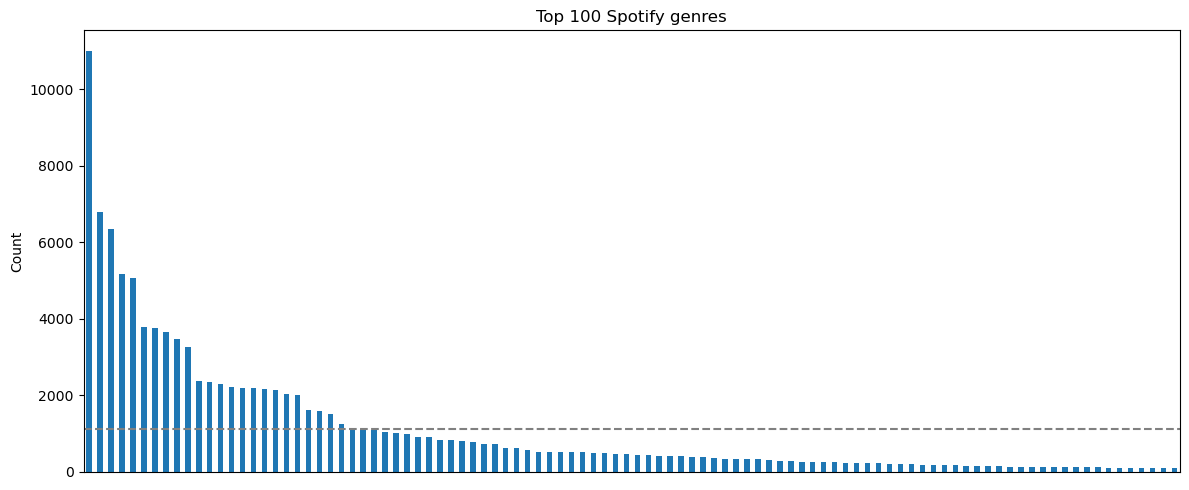

In [12]:

top_n = 100
top_counts = genre_counts.head(top_n)
y_mean = top_counts.mean()

plt.figure(figsize=(12, 5))
top_counts.plot(kind="bar")
plt.axhline(y_mean, linestyle="--", color='grey') # Add grey line representing the mean
plt.title(f"Top {min(top_n, len(genre_counts))} Spotify genres")
plt.xlabel("")
plt.ylabel("Count")

# Hide x-axis labels to keep the chart readable
plt.xticks([], [])
plt.tight_layout()
plt.show()


### Grouping genres into buckets

We’ll map specific labels to a small set of buckets:
- **pop** (pop, art pop, synthpop, hyperpop, britpop, etc.)
- **rock** (rock, indie rock, classic/prog/alt/shoegaze/post-rock)
- **hip_hop_rap** (hip hop, rap, trap, drill, boom bap, etc.)
- **rnb_soul** (r&b, neo soul, soul, motown)
- **electronic_dance** (edm, house, techno, trance, downtempo, vaporwave, future house, etc.)
- **jazz** (jazz, bebop, hard bop, fusion, vocal jazz, nu jazz, etc.)
- **classical_art** (classical, chamber, opera, minimalism, neoclassical, soundtrack/stage)
- **folk_country_americana** (folk, alt country, bluegrass, americana, singer-songwriter)
- **metal_hard** (metal, hardcore, metalcore, thrash, sludge, stoner, grindcore, etc.)
- **latin** (latin pop/jazz/folk, mpb, bossa nova, cumbia, reggaeton, salsa, bachata, etc.)
- **world_regional** (afrobeats/afrobeat/highlife/gnawa, fado, flamenco, k-pop/j-pop/mandopop, etc.)
- **experimental_avant** (experimental, avant-garde, noise, idm, ambient/drone, post-whatever)
- **other** (comedy, spoken word, reggae, rocksteady, dancehall, dub, “unknown”)

In [13]:
BUCKET_RULES = [
    ("hip_hop_rap",       ["hip hop", "rap", "trap", "drill", "boom bap", "g-funk", "grime"]),
    ("rnb_soul",          ["r&b", "rnb", "soul", "motown", "new jack swing", "neo soul", "philly soul"]),
    ("electronic_dance",  ["edm", "house", "techno", "trance", "disco", "vaporwave", "ambient", "downtempo",
                           "future house", "future bass", "progressive house", "slap house", "garage", "chillstep",
                           "chillwave", "psytrance", "moombahton", "big room", "eurodance", "italo disco",
                           "jersey club", "nightcore", "stutter house", "disco house", "dubstep", "electroclash"]),
    ("jazz",              ["jazz", "bebop", "hard bop", "fusion", "vocal jazz", "nu jazz", "cool jazz", "free jazz",
                           "jazz funk", "jazz house", "jazz blues", "jazz beats"]),
    ("classical_art",     ["classical", "chamber", "opera", "neoclassical", "minimalism", "baroque",
                           "soundtrack", "musicals", "orchestral"]),
    ("folk_country_americana", ["folk", "bluegrass", "americana", "singer-songwriter", "country", "alt country"]),
    ("metal_hard",        ["metal", "hardcore", "thrash", "grindcore", "sludge", "stoner", "post-hardcore",
                           "metalcore", "gothic metal", "power metal", "black metal", "nu metal", "melodic death"]),
    ("rock",              ["rock", "shoegaze", "post-rock", "post-punk", "proto-punk", "new wave", "glam rock",
                           "progressive rock", "math rock", "indie rock", "garage rock", "hard rock", "space rock",
                           "grunge", "power pop", "yacht rock", "classic rock", "art rock", "riot grrrl", "punk",
                           "surf rock", "rap rock", "krautrock"]),
    ("pop",               [" pop", "synthpop", "hyperpop", "art pop", "bedroom pop", "indie pop", "dance pop",
                           "power pop", "pop punk", "britpop", "city pop", "soft pop"]),
    ("latin",             ["latin", "mpb", "bossa nova", "samba", "cumbia", "reggaeton", "salsa", "bachata",
                           "bolero", "sertanejo", "pagode", "tecnobrega", "neoperreo", "calypso", "forro", "forró"]),
    # ("reggae_dancehall",  ["reggae", "dancehall", "rocksteady", "dub"]),
    ("world_regional",    ["fado", "flamenco", "afrobeat", "afrobeats", "highlife", "gnawa",
                           "k-pop", "kpop", "k-rap", "k rap", "k-rock", "k rock",
                           "j-pop", "jpop", "j-rap", "j rap", "j-rock", "j rock", "j-r&b", "mandopop",
                           "celtic", "mariachi", "kizomba", "kuduro", "bhangra", "pagode baiano",
                           "sertanejo", "funk carioca", "brazilian funk", "brazilian hip hop",
                           "turkish hip hop", "german hip hop", "french rap"]),
    ("experimental_avant",["experimental", "avant", "noise", "idm", "drone", "witch house", "psych", "post-"]),
]

def map_genre_to_bucket(genre):
    if not isinstance(genre, str) or not genre:
        return "other"
    g = genre.lower().strip()
    for bucket, needles in BUCKET_RULES:
        for needle in needles:
            if needle in g:
                return bucket
    if g in {"spoken word", "comedy"}:
        return "other"
    return "other"


In [14]:
# Map each unique genre to a bucket
unique_genres = pd.Series(sorted(flat_genres.unique()), name="genre")
bucket_df = unique_genres.to_frame().assign(bucket=unique_genres.map(map_genre_to_bucket))

bucket_counts = flat_genres.map(map_genre_to_bucket).value_counts()
y_mean_bucket = bucket_counts.mean()

# Also show bucket counts as a dataframe
bucket_counts_df = bucket_counts.rename_axis("bucket").reset_index(name="count")
bucket_counts_df


,bucket,count
0,hip_hop_rap,38159
1,rock,14191
2,pop,14003
3,other,12522
4,folk_country_americana,6805
5,rnb_soul,6747
6,classical_art,5618
7,world_regional,4042
8,latin,3478
9,jazz,2623


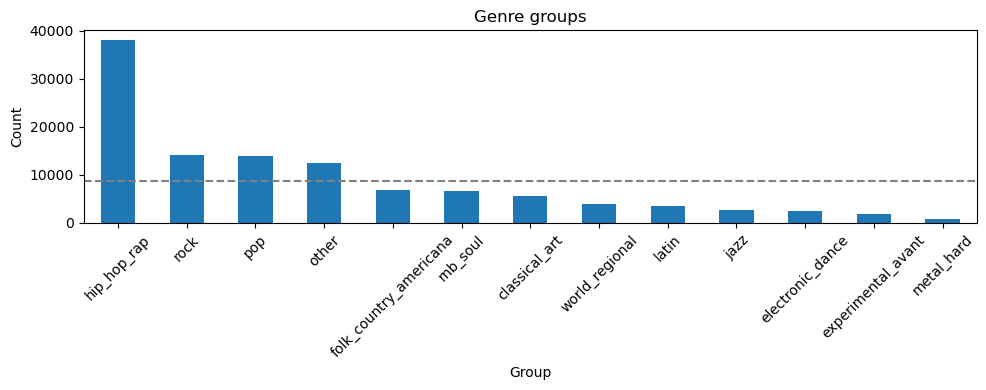

In [15]:
plt.figure(figsize=(10, 4))
bucket_counts.plot(kind="bar")
plt.axhline(y_mean_bucket, linestyle="--", color='grey')
plt.title("Genre groups")
plt.xlabel("Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---


# Cleaning Path

We will prepare the data so it is consistent and easy to use later.

Plan:
- Group genres into simple buckets.
- Create a cleaned dataset with consistent dates, one duration field, basic numeric fixes, and the grouped genres.
- Load the cleaned data again, check it, and continue the analysis.

Cleaning runs outside this notebook in `song-of-the-week/core/scripts/clean_dataset.py`.  
Here we will only load the cleaned data for feature engineering and model training.

In [16]:
clean_path = processed_dir / "dataset_clean.csv"

df = pd.read_csv(clean_path, low_memory=False)

# Visual EDA

Now that we are done with the "Problem Checks", we'll move on to a more visual EDA

### Weekly activity
Line chart of total scrobbles per week.


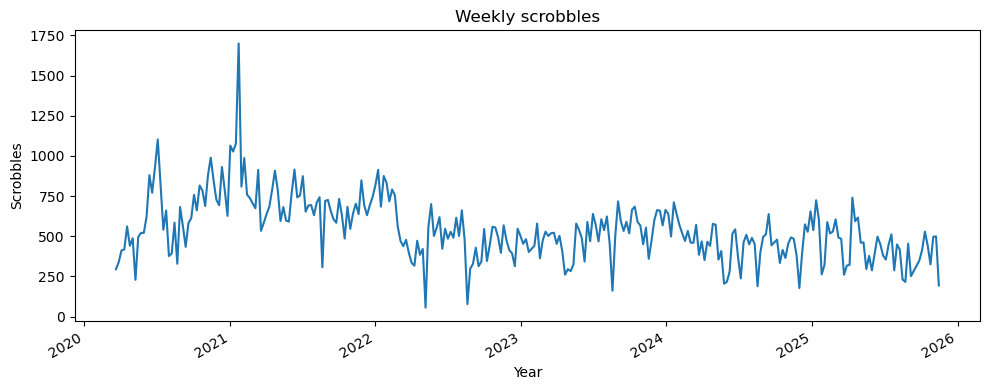

In [18]:
df_w = (
    df.groupby("week_saturday_utc", dropna=False)
      .size()
      .rename("scrobbles")
      .reset_index()
      .sort_values("week_saturday_utc")
)

# Make sure the x column is datetime
df_w["week_saturday_utc"] = pd.to_datetime(df_w["week_saturday_utc"], utc=True, errors="coerce")

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_w["week_saturday_utc"], df_w["scrobbles"])
ax.set_title("Weekly scrobbles")
ax.set_xlabel("Year")
ax.set_ylabel("Scrobbles")


fig.autofmt_xdate()
plt.tight_layout()
plt.show()

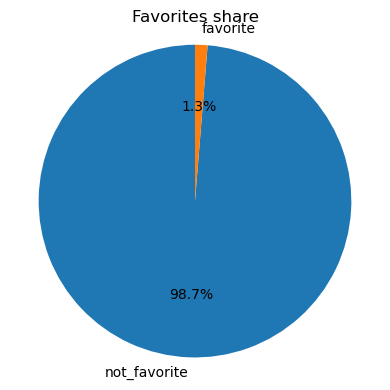

In [19]:
fav_counts = df["is_week_favorite"].value_counts().rename({0:"not_favorite", 1:"favorite"})

fig, ax = plt.subplots(figsize=(4,4))
ax.pie(fav_counts.values, labels=fav_counts.index, autopct="%1.1f%%", startangle=90)
ax.set_title("Favorites share")
ax.axis("equal")
plt.tight_layout()
plt.show()

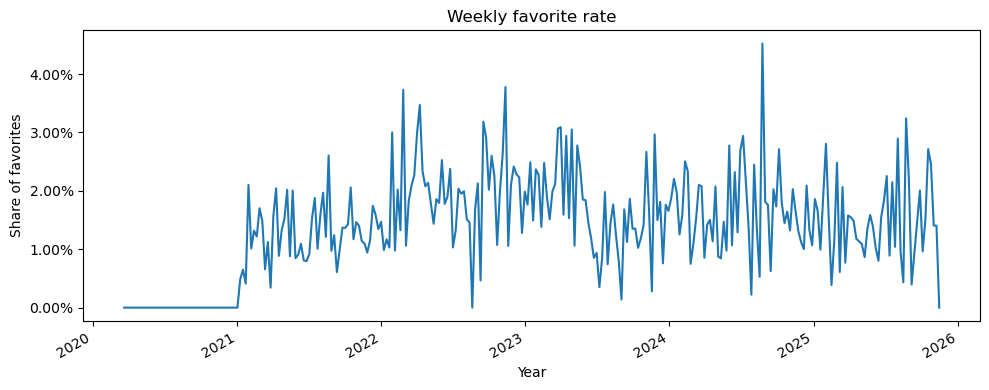

In [20]:
# Weekly favorite rate
fav_week = (
    df.groupby("week_saturday_utc")["is_week_favorite"]
      .mean()
      .rename("favorite_rate")
      .reset_index()
      .sort_values("week_saturday_utc")
)
fav_week["week_saturday_utc"] = pd.to_datetime(fav_week["week_saturday_utc"], utc=True, errors="coerce")

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(fav_week["week_saturday_utc"], fav_week["favorite_rate"])
ax.set_title("Weekly favorite rate")
ax.set_xlabel("Year")
ax.set_ylabel("Share of favorites")

# y as percent
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


## Top artists and tracks (top 20)
Bar charts with the mean line; labels removed to keep things readable.


                             artist  scrobbles
0  King Gizzard & The Lizard Wizard       5445
1                        Kanye West       4653
2                    Sufjan Stevens       4401
3                         JPEGMAFIA       3644
4                     Freddie Gibbs       2325
5                       Ichiko Aoba       2264
6                    Kendrick Lamar       2030
7                       David Bruno       2022
8                       Beach House       1948
9                       Fleet Foxes       1947

Mean top 100 artists: 906.92


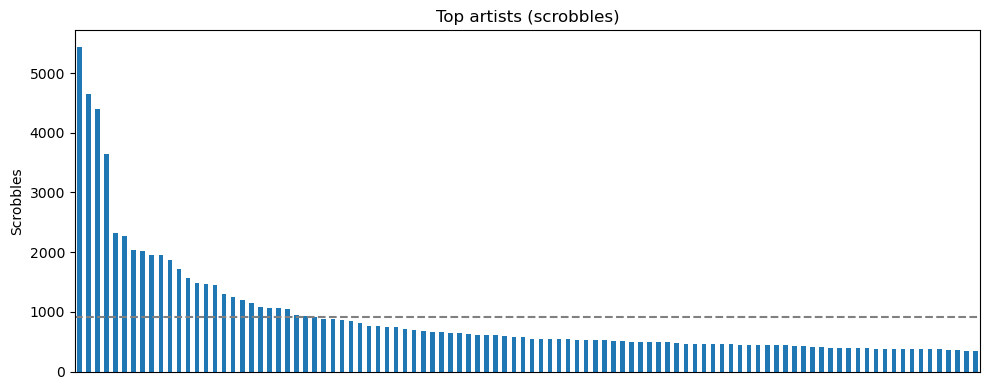

In [21]:
# Top artists
top_n = 100
top_artists = df["artist_name"].value_counts().head(top_n)
y_mean = top_artists.mean()

print(top_artists.head(10).rename_axis("artist").reset_index(name="scrobbles"))
print(f'\nMean top 100 artists: {y_mean}')

plt.figure(figsize=(10,4))
top_artists.plot(kind="bar")
plt.axhline(y_mean, linestyle="--", color='grey')
plt.title("Top artists (scrobbles)")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.xticks([], [])
plt.tight_layout()
plt.show()


                              track_name              artist_name  scrobbles
0                               Concorde  Black Country, New Road        124
1                           Weird Fishes          Lianne La Havas        116
2                       Basketball Shoes  Black Country, New Road        114
3                     Chaos Space Marine  Black Country, New Road        111
4                          Feel the Love          KIDS SEE GHOSTS        104
5                       HAZARD DUTY PAY!                JPEGMAFIA        103
6                     Helplessness Blues              Fleet Foxes        100
7                             Sunglasses  Black Country, New Road         98
8                                Runaway               Kanye West         97
9  The Place Where He Inserted The Blade  Black Country, New Road         96

Mean top 100 tracks: 76.06


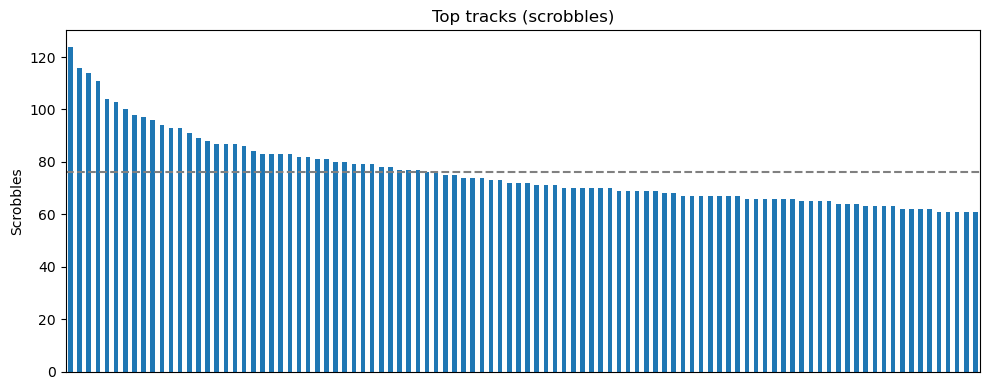

In [22]:
# Top tracks
top_tracks = df[["track_name", 'artist_name']].value_counts().head(top_n)
y_mean = top_tracks.mean()

print(top_tracks.head(10).reset_index(name="scrobbles"))
print(f'\nMean top 100 tracks: {y_mean}')

plt.figure(figsize=(10,4))
top_tracks.plot(kind="bar")
plt.axhline(y_mean, linestyle="--", color='grey')
plt.title("Top tracks (scrobbles)")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.xticks([], [])
plt.tight_layout()
plt.show()


## Popularity and duration (side by side)
Left: Spotify popularity. Right: track duration (seconds), with all 1000+ seconds in one bucket.  

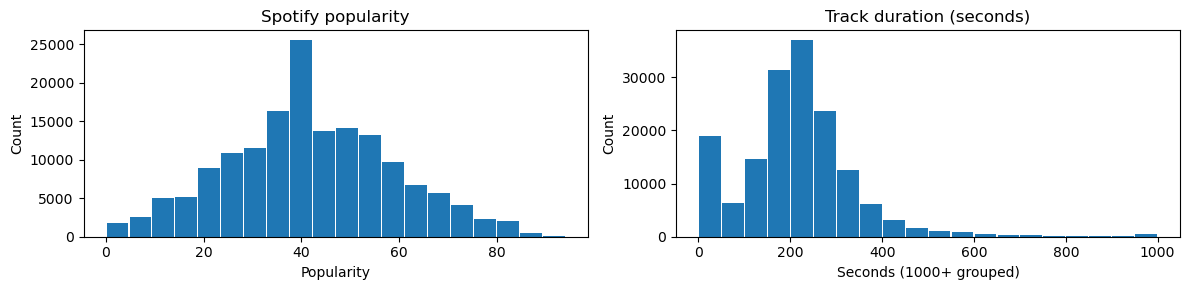

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))

# Left: Spotify popularity
if "spotify_popularity" in df.columns:
    s = pd.to_numeric(df["spotify_popularity"], errors="coerce").dropna()
    axes[0].hist(s, bins=20, rwidth=0.95)  # rwidth < 1.0 creates a small gap
    axes[0].set_title("Spotify popularity")
    axes[0].set_xlabel("Popularity")
    axes[0].set_ylabel("Count")

# Right: Track duration with 1000+ bucket
if "track_duration" in df.columns:
    d = pd.to_numeric(df["track_duration"], errors="coerce").dropna()
    d_capped = d.where(d <= 1000, 1000)  # put all >1000 into 1000 bin
    # bins from 0 to 1000, plus the final 1000 bucket
    bins = list(range(0, 1001, 50))
    axes[1].hist(d_capped, bins=bins, rwidth=0.95)
    axes[1].set_title("Track duration (seconds)")
    axes[1].set_xlabel("Seconds (1000+ grouped)")
    axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

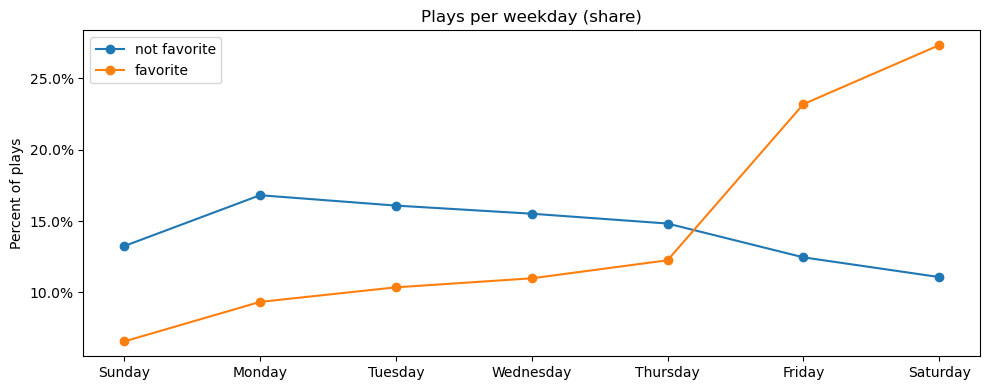

In [24]:
dt = pd.to_datetime(df["date"], utc=True, errors="coerce")
dow_name = dt.dt.day_name()

order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

mask_fav = df["is_week_favorite"] == 1
pct_fav = dow_name[mask_fav].value_counts(normalize=True).reindex(order).fillna(0)
pct_non = dow_name[~mask_fav].value_counts(normalize=True).reindex(order).fillna(0)

x = np.arange(len(order))

plt.figure(figsize=(10,4))
plt.plot(x, pct_non.values, marker="o", label="not favorite")
plt.plot(x, pct_fav.values, marker="o", label="favorite")
plt.title("Plays per weekday (share)")
plt.xlabel("")
plt.ylabel("Percent of plays")
plt.xticks(x, order)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout()
plt.show()

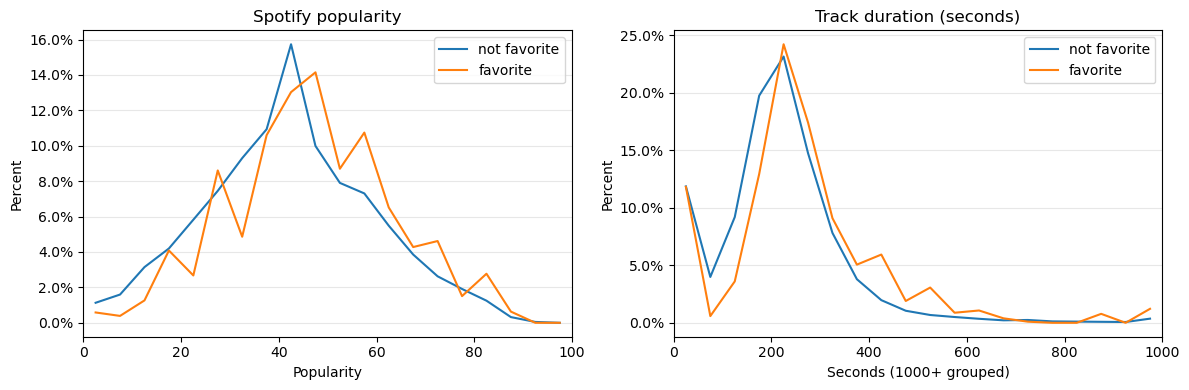

In [25]:
def line_dist_percent(series, bins):
    """Return bin centers and % per bin (sums to 100%)."""
    s = pd.to_numeric(series, errors="coerce").dropna()
    counts, edges = np.histogram(s, bins=bins)
    pct = counts / counts.sum() * 100 if counts.sum() > 0 else counts.astype(float)
    centers = (edges[:-1] + edges[1:]) / 2.0
    return centers, pct

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Left: Spotify popularity (0–100)
if "spotify_popularity" in df.columns:
    pop_bins = np.arange(0, 101, 5)
    fav_mask = df["is_week_favorite"] == 1

    x0, y0 = line_dist_percent(df.loc[~fav_mask, "spotify_popularity"], pop_bins)
    x1, y1 = line_dist_percent(df.loc[fav_mask,  "spotify_popularity"], pop_bins)

    ax = axes[0]
    ax.plot(x0, y0, label="not favorite")
    ax.plot(x1, y1, label="favorite")
    ax.set_title("Spotify popularity")
    ax.set_xlabel("Popularity")
    ax.set_ylabel("Percent")
    ax.set_xlim(pop_bins[0], pop_bins[-1])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend()
    ax.grid(True, axis="y", alpha=0.3)

# Right: Track duration (seconds), 1000+ grouped
if "track_duration" in df.columns:
    dur_bins = np.arange(0, 1001, 50)
    fav_mask = df["is_week_favorite"] == 1
    # cap >1000 to 1000 so they land in last bin
    dur = pd.to_numeric(df["track_duration"], errors="coerce").clip(upper=1000)
    x0, y0 = line_dist_percent(dur[~fav_mask], dur_bins)
    x1, y1 = line_dist_percent(dur[fav_mask],  dur_bins)

    ax = axes[1]
    ax.plot(x0, y0, label="not favorite")
    ax.plot(x1, y1, label="favorite")
    ax.set_title("Track duration (seconds)")
    ax.set_xlabel("Seconds (1000+ grouped)")
    ax.set_ylabel("Percent")
    ax.set_xlim(dur_bins[0], dur_bins[-1])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend()
    ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


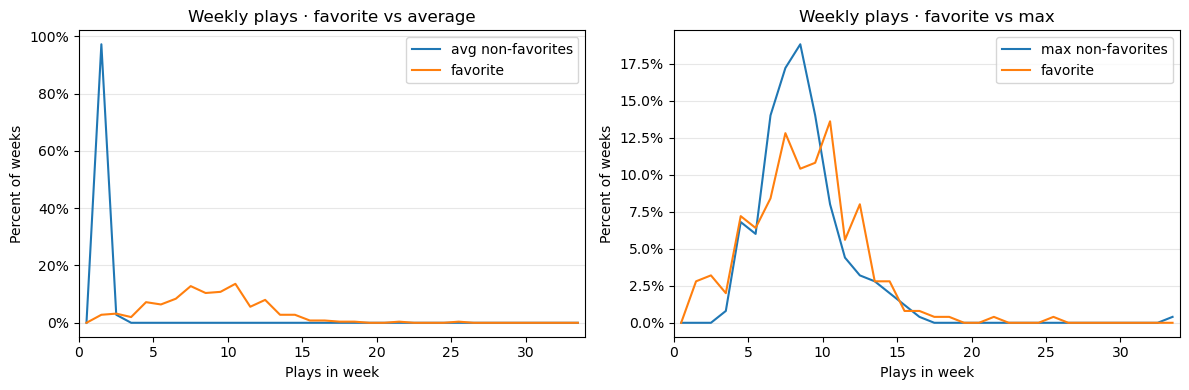

In [26]:
keys = ["artist_name", "track_name", "week_saturday_utc"]
have = [c for c in keys if c in df.columns]

agg = (
    df.groupby(have, dropna=False, as_index=False)
      .agg(plays=("track_name","size"), is_fav=("is_week_favorite","max"))
)

fav_week_plays = (
    agg[agg["is_fav"]==1]
    .groupby("week_saturday_utc", as_index=False)["plays"].max()
    .rename(columns={"plays":"fav_plays"})
)

nonfav_week = agg[agg["is_fav"]==0].groupby("week_saturday_utc")["plays"]
nonfav_avg = nonfav_week.mean().rename("avg_nonfav_plays").reset_index()
nonfav_max = nonfav_week.max().rename("max_nonfav_plays").reset_index()

cmp = fav_week_plays.merge(nonfav_avg, on="week_saturday_utc", how="inner")\
                    .merge(nonfav_max, on="week_saturday_utc", how="inner")

# Shared x scale
xmax = int(np.nanmax(cmp[["fav_plays","avg_nonfav_plays","max_nonfav_plays"]].to_numpy())) if len(cmp) else 10
bins = np.arange(0, xmax + 1)

def norm_hist(series, bins):
    counts, edges = np.histogram(series, bins=bins)
    pct = counts / counts.sum() * 100 if counts.sum() > 0 else counts.astype(float)
    centers = (edges[:-1] + edges[1:]) / 2.0
    return centers, pct

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Left: favorite vs average non-favorites
x_f, y_f = norm_hist(cmp["fav_plays"], bins)
x_a, y_a = norm_hist(cmp["avg_nonfav_plays"], bins)

ax = axes[0]
ax.plot(x_a, y_a, label="avg non-favorites")
ax.plot(x_f, y_f, label="favorite")
ax.set_title("Weekly plays · favorite vs average")
ax.set_xlabel("Plays in week")
ax.set_ylabel("Percent of weeks")
ax.set_xlim(0, xmax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()
ax.grid(True, axis="y", alpha=0.3)

# Right: favorite vs max non-favorites
x_m, y_m = norm_hist(cmp["max_nonfav_plays"], bins)

ax = axes[1]
ax.plot(x_m, y_m, label="max non-favorites")
ax.plot(x_f, y_f, label="favorite")
ax.set_title("Weekly plays · favorite vs max")
ax.set_xlabel("Plays in week")
ax.set_ylabel("Percent of weeks")
ax.set_xlim(0, xmax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

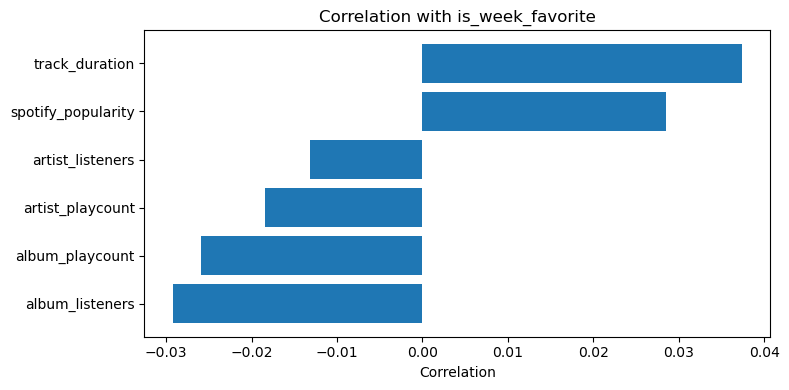

In [27]:
# Numeric columns except the target itself
num_cols = ["track_duration", "spotify_popularity", "artist_listeners", "artist_playcount", "album_playcount", "album_listeners"]

corr = df[num_cols + ["is_week_favorite"]].corr(numeric_only=True)["is_week_favorite"].drop("is_week_favorite")
corr_sorted = corr.sort_values(ascending=False)

corr_df = corr_sorted.rename_axis("feature").reset_index(name="correlation")
corr_df.head(10)
plt.figure(figsize=(8, 4))
plt.barh(corr_sorted.index[::-1], corr_sorted.values[::-1])
plt.title("Correlation with is_week_favorite")
plt.xlabel("Correlation")
plt.ylabel("")
plt.tight_layout()
plt.show()